In [46]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from datasets import load_dataset

# Configuration and Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Load the Dataset
dataset = load_dataset("D3STRON/music_lyrics_500k")
train_dataset = dataset['train']
test_dataset = dataset['test']

# Convert to pandas DataFrame for convenience
train_df = train_dataset.to_pandas()

# Load and Process NRC Emotional Lexicon
NRC_PATH = 'NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'  

emotions = set(["anger","anticipation","disgust","fear","joy","negative","positive","sadness","surprise","trust"])
emotion_lexicon = {}

# The NRC Lexicon formatting
with open(NRC_PATH, 'r') as f:
    for line in f:
        word, emotion, value = line.strip().split('\t')
        value = int(value)
        if emotion in emotions and value == 1:
            if word not in emotion_lexicon:
                emotion_lexicon[word] = {e:0 for e in emotions}
            emotion_lexicon[word][emotion] = 1

# Tokenizer Setup
vocab = {"[UNK]": 0}
for i, w in enumerate(emotion_lexicon.keys()):
    vocab[w] = i + 1

tokenizer = Tokenizer(WordLevel(vocab=vocab, unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Function to Compute Emotion Scores Using the Tokenizer
def fast_compute_emotion_scores(lyrics, lexicon):
    # Tokenize the lyrics
    tokens = tokenizer.encode(lyrics).tokens
    scores = {e: 0 for e in emotions}
    for token in tokens:
        if token in lexicon:
            # Add emotion values from the lexicon
            for e in emotions:
                scores[e] += lexicon[token][e]
    return scores

# Sample Subset (Randomized)
sample_size = 500000
if len(train_df) > sample_size:
    train_df = train_df.sample(n=sample_size, random_state=None)  # Random subset

# Compute Emotion Scores for Each Lyric
all_scores = []
for lyric in tqdm(train_df['Lyric'], desc="Computing emotion scores"):
    scores = fast_compute_emotion_scores(lyric, emotion_lexicon)
    all_scores.append(scores)

emotion_scores_df = pd.DataFrame(all_scores)
train_df = pd.concat([train_df, emotion_scores_df], axis=1)

print("Emotion scores Computed")



Using device: cuda



omputing emotion scores: 100%|███████████████████████████████████| 500000/500000 [01:19<00:00, 6265.56it/s]

Emotion scores Computed


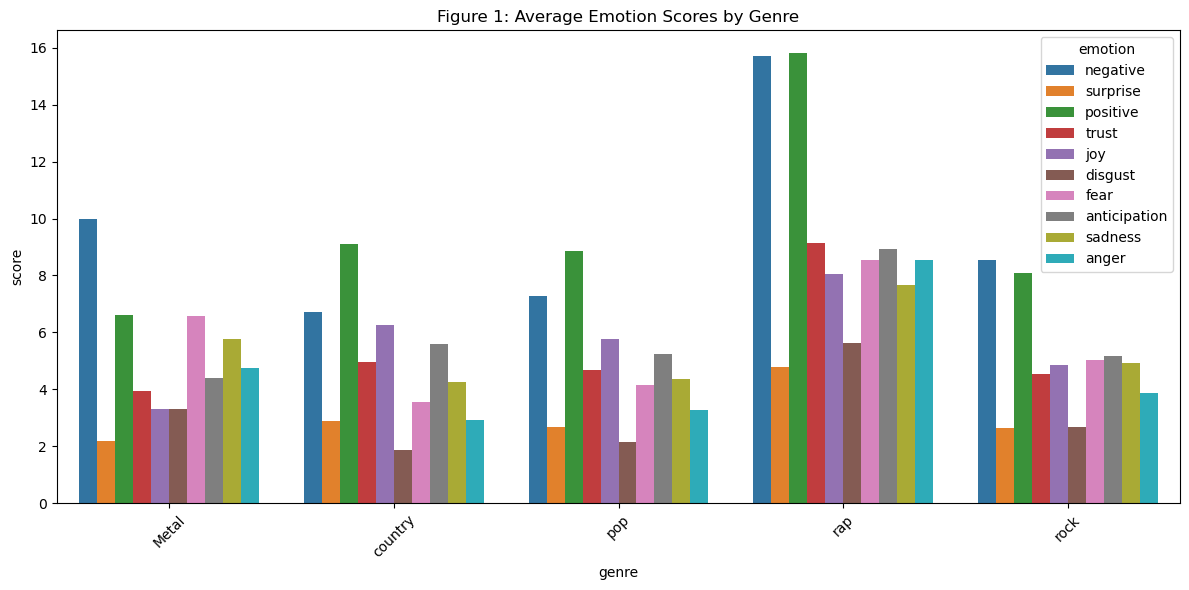

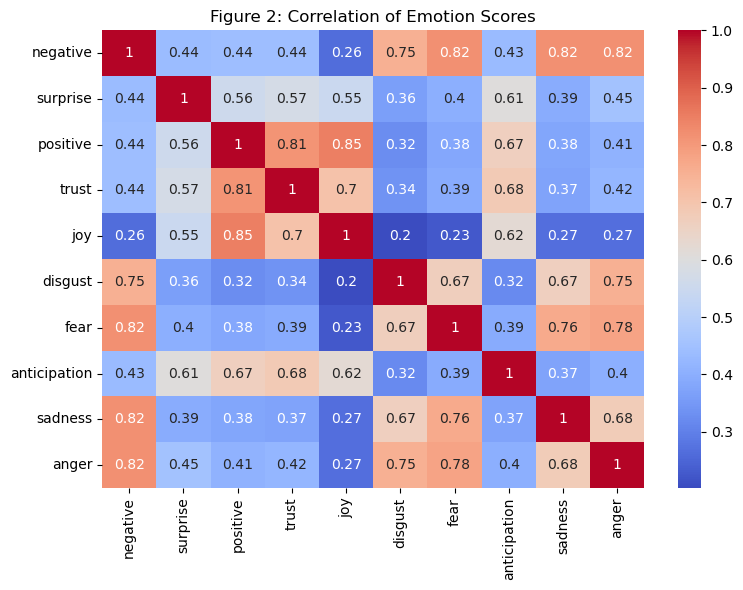

In [47]:
# Data Analysis and Visualization

# 1. Average Emotion Scores by Genre
emotion_means_by_genre = train_df.groupby('genre')[list(emotions)].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(
    data=emotion_means_by_genre.melt(id_vars='genre', var_name='emotion', value_name='score'), 
    x='genre', y='score', hue='emotion'
)
plt.title("Figure 1: Average Emotion Scores by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_emotion_by_genre.png")
plt.show()

# 2. Correlation of Emotions
corr = train_df[list(emotions)].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Figure 2: Correlation of Emotion Scores")
plt.tight_layout()
plt.savefig("emotion_correlation.png")
plt.show()


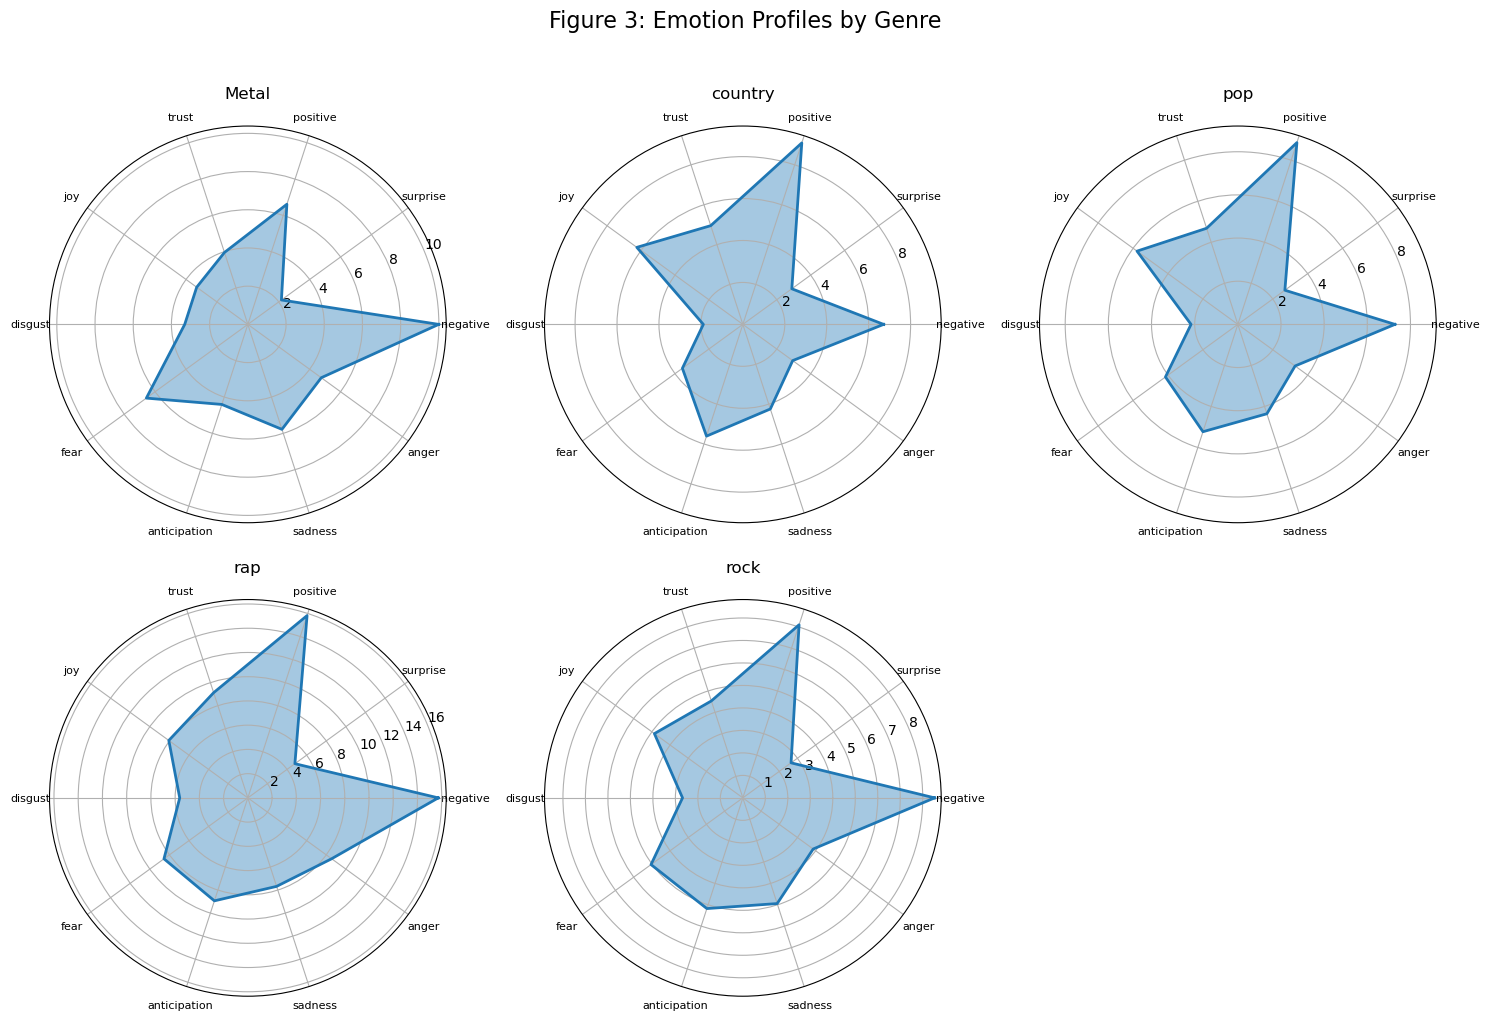

In [48]:
from math import pi

def plot_multiple_radar_charts(data, emotions, genres_per_row=3):
    genres = data.index[:6]  # Select up to 6 genres for demonstration
    num_genres = len(genres)
    
    # Create subplots: 2 rows, dynamically adjust columns
    rows = (num_genres // genres_per_row) + (num_genres % genres_per_row > 0)
    fig, axes = plt.subplots(rows, genres_per_row, figsize=(15, 10),
                             subplot_kw=dict(polar=True))
    
    # Flatten axes for easy indexing
    axes = axes.flatten()
    
    # Calculate angles for radar chart
    angles = [n / float(len(emotions)) * 2 * pi for n in range(len(emotions))]
    angles += angles[:1]

    # Loop through each genre and plot its radar chart
    for i, genre in enumerate(genres):
        ax = axes[i]
        
        # Get genre-specific data and close the radar chart
        genre_data = data.loc[genre].values.flatten().tolist()
        genre_data += genre_data[:1]

        # Plot the radar chart
        ax.plot(angles, genre_data, linewidth=2, linestyle='solid', label=genre)
        ax.fill(angles, genre_data, alpha=0.4)

        # Set up the labels and title
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(emotions, fontsize=8)
        ax.set_title(genre, size=12, pad=10)
        
        # Remove the legend for cleaner output
        ax.legend().remove()
    
    # Remove empty axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Figure 3: Emotion Profiles by Genre", size=16, y=1.02)
    plt.tight_layout()
    plt.savefig("multi_genre_radar_charts.png")
    plt.show()


# Prepare the data
emotion_means_by_genre = train_df.groupby('genre')[list(emotions)].mean()

# Plot radar charts for multiple genres
plot_multiple_radar_charts(emotion_means_by_genre, list(emotions), genres_per_row=3)


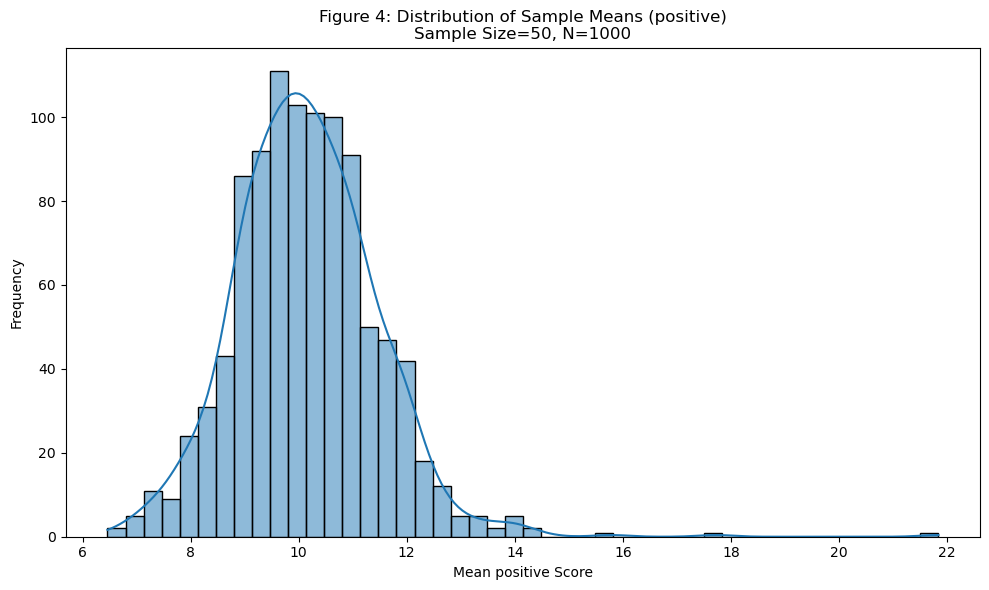

In [49]:
# Central Limit Theorem
def plot_clt_example(df, emotion='positive', threshold=1, sample_size=50, n_samples=1000):
    # Filter tracks to those considered "positive"
    positive_tracks = df[df[emotion] >= threshold]
    
    means = []
    for _ in range(n_samples):
        sample = positive_tracks[emotion].sample(sample_size, replace=True)
        means.append(sample.mean())
    
    plt.figure(figsize=(10,6))
    sns.histplot(means, kde=True)
    plt.title(f"Figure 4: Distribution of Sample Means ({emotion})\nSample Size={sample_size}, N={n_samples}")
    plt.xlabel(f"Mean {emotion} Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("clt_example.png")
    plt.show()

# Here we consider "positive" tracks as those with positive > 1, 
plot_clt_example(train_df, emotion='positive', threshold=1, sample_size=50, n_samples=1000)